## Load data

In [1]:
import numpy as np

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#datapath = '/media/sf_VBox_Shared/timeseries/UCR_WaveGesture/'
datapath = '/media/sf_VBox_Shared/timeseries/PAMAP2_Dataset/slidingwindow500last/'

In [4]:
X_train = np.load(datapath+'X_train.npy')
y_train_binary = np.load(datapath+'y_train_binary.npy')
X_val = np.load(datapath+'X_val.npy')
y_val_binary = np.load(datapath+'y_val_binary.npy')
X_test = np.load(datapath+'X_test.npy')
y_test_binary = np.load(datapath+'y_test_binary.npy')

print(X_train.shape)

(21397, 500, 9)


In [5]:
num_classes = y_train_binary.shape[1]
print(num_classes)

13


## Generate models

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

Using Theano backend.


In [7]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen

In [8]:
models = modelgen.generate_models(X_train.shape, num_classes, number_of_models = 5, model_type = None)

In [9]:
for model, params, model_types in models:
    print(params)
    model.summary()

{'filters': array([16, 91, 64, 34, 80, 40, 28, 56]), 'lstm_dims': array([72, 58]), 'learning_rate': 0.00016708514927986132}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
reshape_1 (Reshape)                (None, 1, 500, 9)   0           reshape_input_1[0][0]            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)    (None, 16, 500, 9)  64          reshape_1[0][0]                  
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 16, 500, 9)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 91, 500, 9)  4459        a

## Compare models

In [10]:
# Only take small trainset
subsize_set = 100
X_train_sub = X_train[:subsize_set,:,:]
y_train_binary_sub = y_train_binary[:subsize_set,:]

In [11]:
nr_epochs = 5

histories = []
val_accuracies = []
val_losses = []
for model, params, model_types in models:
    history = model.fit(X_train_sub, y_train_binary_sub,
              nb_epoch=nr_epochs,batch_size=20, validation_data=(X_val, y_val_binary))
    histories.append(history)
    val_accuracies.append(history.history['val_acc'][-1])
    val_losses.append(history.history['val_loss'][-1])

Train on 100 samples, validate on 3131 samples
Epoch 1/5
100/100 [==============================] - 129s - loss: 7.6030 - acc: 0.0500 - val_loss: 2.4706 - val_acc: 0.2242
Epoch 2/5
100/100 [==============================] - 143s - loss: 7.3769 - acc: 0.2200 - val_loss: 2.3888 - val_acc: 0.2699
Epoch 3/5
100/100 [==============================] - 122s - loss: 7.2140 - acc: 0.3700 - val_loss: 2.3194 - val_acc: 0.3328
Epoch 4/5
100/100 [==============================] - 121s - loss: 7.0368 - acc: 0.3500 - val_loss: 2.2654 - val_acc: 0.3331
Epoch 5/5
100/100 [==============================] - 131s - loss: 6.9377 - acc: 0.4000 - val_loss: 2.2419 - val_acc: 0.3338
Train on 100 samples, validate on 3131 samples
Epoch 1/5
100/100 [==============================] - 172s - loss: 8.1597 - acc: 0.1500 - val_loss: 2.4267 - val_acc: 0.2571
Epoch 2/5
100/100 [==============================] - 185s - loss: 6.9326 - acc: 0.3100 - val_loss: 2.4415 - val_acc: 0.2571
Epoch 3/5
100/100 [===================

In [12]:
def plotTrainingProcess(history, name='Model', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax2 = ax.twinx()
    LN = len(history.history['val_loss'])
    val_loss, = ax.plot(range(LN),history.history['val_loss'],'g--', label='validation loss')
    train_loss, = ax.plot(range(LN),history.history['loss'],'g-', label='train loss')
    val_acc, = ax2.plot(range(LN),history.history['val_acc'],'b--', label='validation accuracy')
    train_acc, = ax2.plot(range(LN),history.history['acc'],'b-', label='train accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss',color='g')
    ax2.set_ylabel('accuracy',color='b')
    plt.legend(handles=[val_loss, train_loss, val_acc, train_acc], loc=2, bbox_to_anchor=(1.1, 1))
    plt.title(name)

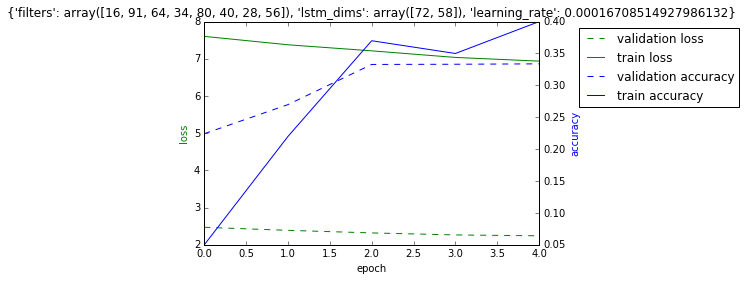

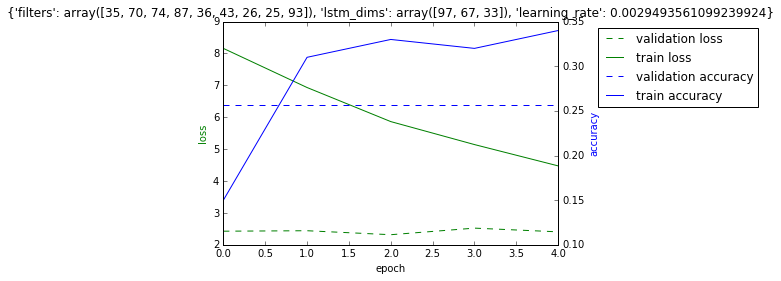

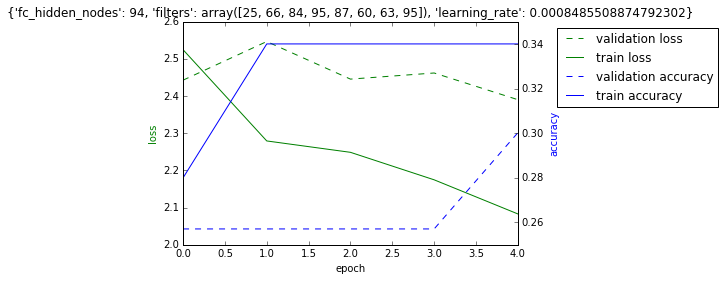

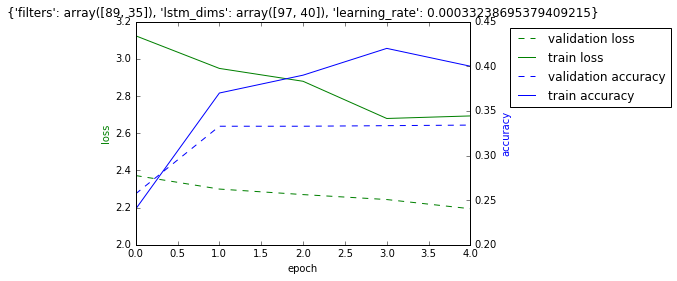

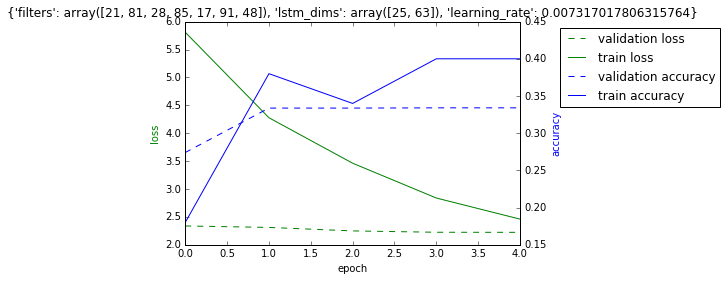

In [13]:
for i in range(len(models)):
    name = str(models[i][1])
    plotTrainingProcess(histories[i], name)

In [14]:
import pandas as pd

results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'filters': array([16, 91, 64, 34, 80, 40, 28,...",0.40,6.937658,0.333759,2.241948
1,"{'filters': array([35, 70, 74, 87, 36, 43, 26,...",0.34,4.474931,0.257106,2.406265
2,"{'fc_hidden_nodes': 94, 'filters': array([25, ...",0.34,2.082990,0.300224,2.390106
3,"{'filters': array([89, 35]), 'lstm_dims': arra...",0.40,2.692863,0.334079,2.193846
4,"{'filters': array([21, 81, 28, 85, 17, 91, 48]...",0.40,2.459993,0.334079,2.223350


## Train the best model for real

In [18]:
#best_model_index = np.argmax(val_accuracies)
best_model_index = 3

In [19]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

3 DeepConvLSTM {'filters': array([89, 35]), 'lstm_dims': array([97, 40]), 'learning_rate': 0.00033238695379409215}


In [23]:
nr_epochs = 5 # 10
datasize = 1000
history = model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 1000 samples, validate on 3131 samples
Epoch 1/5
1000/1000 [==============================] - 266s - loss: nan - acc: 0.3310 - val_loss: nan - val_acc: 0.2571
Epoch 2/5
1000/1000 [==============================] - 221s - loss: nan - acc: 0.3310 - val_loss: nan - val_acc: 0.2571
Epoch 3/5
1000/1000 [==============================] - 188s - loss: nan - acc: 0.3310 - val_loss: nan - val_acc: 0.2571
Epoch 4/5
1000/1000 [==============================] - 196s - loss: nan - acc: 0.3310 - val_loss: nan - val_acc: 0.2571
Epoch 5/5
1000/1000 [==============================] - 181s - loss: nan - acc: 0.3310 - val_loss: nan - val_acc: 0.2571


In [ ]:
plotTrainingProcess(history)

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))